In [1]:
# 1. 라이브러리 임포트
import os
import shutil
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
from PIL import Image
import torch
from pathlib import Path
import yaml
import pandas as pd
from sklearn.model_selection import train_test_split
from glob import glob

In [2]:
# 2. GPU 또는 CPU 설정
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cpu


In [3]:
# 3. 모델 및 경로 설정
BASE_DIR = os.path.join(os.getcwd(), "resized")
MODEL_PATH = os.path.join(BASE_DIR, 'best_acne_yolo.pt')
OUTPUT_DIR = os.path.join(BASE_DIR, 'output')
YAML_PATH = os.path.join(BASE_DIR, 'data.yaml')
DATASET_DIR = os.path.join(BASE_DIR, "yolo_dataset")
LABEL_DIR = os.path.join(BASE_DIR, 'labels')  # 실제 레이블 파일(.txt)이 있는 폴더
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(DATASET_DIR, exist_ok=True)
os.makedirs(LABEL_DIR, exist_ok=True)

# 클래스 및 디렉토리 정의
CLASS_NAMES = ['normal', 'mild', 'moderate', 'severe', 'very_severe']
CLASS_ID_MAP = {"normal": 0, "mild": 1, "moderate": 2, "severe": 3, "very_severe": 4}
CLASS_DIRS = {
    "normal": os.path.join(BASE_DIR, "normal"),
    "mild": os.path.join(BASE_DIR, "mild"),
    "moderate": os.path.join(BASE_DIR, "moderate"),
    "severe": os.path.join(BASE_DIR, "severe"),
    "very_severe": os.path.join(BASE_DIR, "very_severe")
}
IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp", ".JPG", ".JPEG", ".PNG")
NUM_CLASSES = 5
EPOCHS = 50
BATCH_SIZE = 16
IMG_SIZE = 416  # 학습 및 감지 이미지 크기 (화질 개선)

# 데이터셋 폴더 생성
train_dir = os.path.join(DATASET_DIR, 'train')
val_dir = os.path.join(DATASET_DIR, 'val')
test_dir = os.path.join(DATASET_DIR, 'test')
os.makedirs(os.path.join(train_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'labels'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'labels'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'labels'), exist_ok=True)

In [4]:
# 4. 이미지 파일 확인 함수
def is_image(p):
    return os.path.isfile(p) and any(p.lower().endswith(ext) for ext in IMG_EXTS)

In [5]:
# 5. 데이터 로드 및 분할 함수
def load_and_split_data():
    rows = []
    for label_name, class_dir in CLASS_DIRS.items():
        if not os.path.isdir(class_dir):
            print(f"[ERROR] Directory not found: {class_dir}")
            continue
        class_files = [p for p in glob(os.path.join(class_dir, "**", "*"), recursive=True) if is_image(p)]
        if not class_files:
            print(f"[ERROR] No images found in: {class_dir}")
            continue
        print(f"Found {len(class_files)} images in {label_name}")
        for fp in class_files:
            rows.append([fp, label_name, CLASS_ID_MAP[label_name]])
    
    if not rows:
        raise ValueError("No images found in any class directories.")
    
    df = pd.DataFrame(rows, columns=["filepath", "label_name", "label_id"])
    out_csv = os.path.join(BASE_DIR, "labels_total.csv")
    df.to_csv(out_csv, index=False)
    print(f"CSV saved: {out_csv}")
    print("Label distribution:\n", df["label_name"].value_counts())
    
    train_df, test_df = train_test_split(df, test_size=0.15, stratify=df["label_name"], random_state=42)
    train_df, val_df = train_test_split(train_df, test_size=0.1765, stratify=train_df["label_name"], random_state=42)
    print("Train dataset size:", len(train_df))
    print("Val dataset size:", len(val_df))
    print("Test dataset size:", len(test_df))
    
    targets = {"normal": 1000, "mild": 800, "moderate": 800, "severe": 1000, "very_severe": 1000}
    rng = np.random.default_rng(42)
    outs = []
    for lab, n in targets.items():
        sub = train_df[train_df["label_name"] == lab]
        if len(sub) >= n:
            outs.append(sub.sample(n=n, random_state=42))
        else:
            idx = rng.choice(sub.index.to_numpy(), size=n, replace=True)
            outs.append(train_df.loc[idx])
    train_bal = pd.concat(outs, ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
    
    train_bal.to_csv(os.path.join(BASE_DIR, "split_train.balanced.csv"), index=False)
    val_df.to_csv(os.path.join(BASE_DIR, "split_val.csv"), index=False)
    test_df.to_csv(os.path.join(BASE_DIR, "split_test.csv"), index=False)
    print("Train balanced:\n", train_bal["label_name"].value_counts())
    print("Val:\n", val_df["label_name"].value_counts())
    print("Test:\n", test_df["label_name"].value_counts())
    
    return train_bal, val_df, test_df

In [6]:
# 6. YOLO 데이터셋 폴더 구조 생성 및 실제 레이블 파일 복사
def organize_yolo_folders(csv_df, dest_folder):
    for _, row in csv_df.iterrows():
        label_id = row['label_id']
        src_path = row['filepath']
        img_dest_dir = os.path.join(dest_folder, 'images')
        label_dest_dir = os.path.join(dest_folder, 'labels')
        dest_img_path = os.path.join(img_dest_dir, os.path.basename(src_path))
        dest_label_path = os.path.join(label_dest_dir, os.path.splitext(os.path.basename(src_path))[0] + '.txt')
        if os.path.exists(src_path):
            shutil.copy(src_path, dest_img_path)
            src_label_path = os.path.join(LABEL_DIR, os.path.splitext(os.path.basename(src_path))[0] + '.txt')
            if os.path.exists(src_label_path):
                shutil.copy(src_label_path, dest_label_path)
            else:
                print(f"[WARNING] Label file not found: {src_label_path}")
                if label_id == 0:  # normal 클래스
                    with open(dest_label_path, 'w') as f:
                        f.write("")  # 빈 파일
                else:
                    print(f"[ERROR] Non-normal class missing label: {src_label_path}")

In [7]:
# 7. YOLO 데이터 YAML 파일 생성
data_yaml = {
    'path': DATASET_DIR,
    'train': 'train/images',
    'val': 'val/images',
    'test': 'test/images',
    'nc': NUM_CLASSES,
    'names': CLASS_NAMES
}
with open(YAML_PATH, 'w') as f:
    yaml.dump(data_yaml, f)
print(f"YAML file created: {YAML_PATH}")

YAML file created: c:\Users\Admin\work space\2nd\resized\data.yaml


In [8]:
# 8. 데이터셋 준비
try:
    train_bal, val_df, test_df = load_and_split_data()
    organize_yolo_folders(train_bal, train_dir)
    organize_yolo_folders(val_df, val_dir)
    organize_yolo_folders(test_df, test_dir)
    print("YOLO folder structure and labels created successfully!")
except Exception as e:
    print(f"[ERROR] Failed to prepare dataset: {e}")

Found 936 images in normal
Found 359 images in mild
Found 95 images in moderate
Found 128 images in severe
Found 90 images in very_severe
CSV saved: c:\Users\Admin\work space\2nd\resized\labels_total.csv
Label distribution:
 label_name
normal         936
mild           359
severe         128
moderate        95
very_severe     90
Name: count, dtype: int64
Train dataset size: 1124
Val dataset size: 242
Test dataset size: 242
Train balanced:
 label_name
very_severe    1000
normal         1000
severe         1000
moderate        800
mild            800
Name: count, dtype: int64
Val:
 label_name
normal         141
mild            54
severe          19
very_severe     14
moderate        14
Name: count, dtype: int64
Test:
 label_name
normal         141
mild            54
severe          19
very_severe     14
moderate        14
Name: count, dtype: int64
[WARNING] Label file not found: c:\Users\Admin\work space\2nd\resized\labels\levle3_84.txt
[ERROR] Non-normal class missing label: c:\Users\Ad

In [9]:
# 9. 학습된 YOLO11 모델 로드
model = YOLO(MODEL_PATH)
model.to(DEVICE)
print(f"Loaded model from: {MODEL_PATH}")

# 클래스 매핑 확인
print("Class names in code:", CLASS_NAMES)
with open(YAML_PATH, 'r') as f:
    yaml_data = yaml.safe_load(f)
print("Class names in data.yaml:", yaml_data['names'])

Loaded model from: c:\Users\Admin\work space\2nd\resized\best_acne_yolo.pt
Class names in code: ['normal', 'mild', 'moderate', 'severe', 'very_severe']
Class names in data.yaml: ['normal', 'mild', 'moderate', 'severe', 'very_severe']


In [10]:
# 10. 재학습 함수
def retrain_model():
    model = YOLO('yolo11n.pt')  # 새 모델 로드
    results = model.train(
        data=YAML_PATH,
        epochs=EPOCHS,
        imgsz=IMG_SIZE,  # 416
        batch=BATCH_SIZE,
        device=DEVICE,
        name='acne_yolo',
        patience=10,
        project=BASE_DIR,
        exist_ok=True,
        augment=True
    )
    model.save(MODEL_PATH)
    print(f"Retrained model saved at: {MODEL_PATH}")

Available columns: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


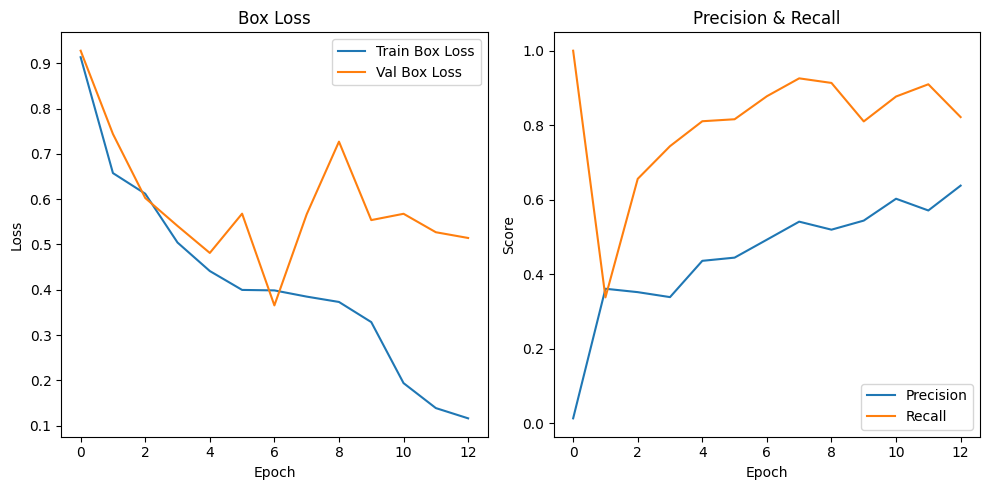

In [11]:
# 11. 학습 결과 시각화
results_csv = os.path.join(BASE_DIR, 'acne_yolo', 'results.csv')
if os.path.exists(results_csv):
    results_df = pd.read_csv(results_csv)
    print("Available columns:", results_df.columns.tolist())
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(results_df['train/box_loss'], label='Train Box Loss')
    plt.plot(results_df['val/box_loss'], label='Val Box Loss')
    plt.title('Box Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(results_df['metrics/precision(B)'], label='Precision')
    plt.plot(results_df['metrics/recall(B)'], label='Recall')
    plt.title('Precision & Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print(f"[ERROR] Results CSV not found at: {results_csv}")

In [12]:
# 12. 이미지에서 여드름 감지 함수
def detect_acne_image(image_path, conf_threshold=0.3, save_output=True):
    img = cv2.imread(image_path)
    if img is None:
        print(f"[ERROR] Image not found: {image_path}")
        return
    
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # 416x416
    results = model.predict(img, conf=conf_threshold, device=DEVICE, verbose=True)
    print(f"Number of detections: {len(results[0].boxes)}")
    
    img_with_boxes = img.copy()
    for result in results:
        boxes = result.boxes.xyxy.cpu().numpy()
        scores = result.boxes.conf.cpu().numpy()
        classes = result.boxes.cls.cpu().numpy()
        
        for box, score, cls in zip(boxes, scores, classes):
            print(f"Detected: {CLASS_NAMES[int(cls)]}, Confidence: {score:.2f}, Box: {box}")
            x1, y1, x2, y2 = map(int, box)
            # 바운딩 박스 크기 축소 (옵션, 필요 시 활성화)
            # scale = 0.8
            # w, h = x2 - x1, y2 - y1
            # x1, y1 = int(x1 + w * (1 - scale) / 2), int(y1 + h * (1 - scale) / 2)
            # x2, y2 = int(x2 - w * (1 - scale) / 2), int(y2 - h * (1 - scale) / 2)
            label = f"{CLASS_NAMES[int(cls)]} {score:.2f}"
            color = (0, 255, 0) if CLASS_NAMES[int(cls)] == 'normal' else (0, 0, 255)
            cv2.rectangle(img_with_boxes, (x1, y1), (x2, y2), color, 1)  # 두께 2 -> 1
            cv2.putText(img_with_boxes, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)  # 텍스트 두께 2 -> 1
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Acne Detection: {os.path.basename(image_path)}")
    plt.show()
    
    if save_output:
        output_path = os.path.join(OUTPUT_DIR, f"detected_{os.path.basename(image_path)}")
        cv2.imwrite(output_path, img_with_boxes)
        print(f"Saved output to: {output_path}")

In [13]:
# 13. 비디오에서 여드름 감지 함수
def detect_acne_video(video_path, conf_threshold=0.3, save_output=True):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"[ERROR] Video not found: {video_path}")
        return
    
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    
    if save_output:
        output_path = os.path.join(OUTPUT_DIR, f"detected_{os.path.basename(video_path)}")
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_input = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))  # 416x416
        results = model.predict(frame_input, conf=conf_threshold, device=DEVICE, verbose=True)
        print(f"Number of detections: {len(results[0].boxes)}")
        
        frame_display = frame.copy()
        scale_x = width / IMG_SIZE
        scale_y = height / IMG_SIZE
        for result in results:
            boxes = result.boxes.xyxy.cpu().numpy()
            scores = result.boxes.conf.cpu().numpy()
            classes = result.boxes.cls.cpu().numpy()
            
            for box, score, cls in zip(boxes, scores, classes):
                print(f"Detected: {CLASS_NAMES[int(cls)]}, Confidence: {score:.2f}, Box: {box}")
                x1, y1, x2, y2 = map(int, box)
                # 원본 프레임에 맞게 스케일링
                x1, y1, x2, y2 = int(x1 * scale_x), int(y1 * scale_y), int(x2 * scale_x), int(y2 * scale_y)
                # 바운딩 박스 크기 축소 (옵션)
                # scale = 0.8
                # w, h = x2 - x1, y2 - y1
                # x1, y1 = int(x1 + w * (1 - scale) / 2), int(y1 + h * (1 - scale) / 2)
                # x2, y2 = int(x2 - w * (1 - scale) / 2), int(y2 - h * (1 - scale) / 2)
                label = f"{CLASS_NAMES[int(cls)]} {score:.2f}"
                color = (0, 255, 0) if CLASS_NAMES[int(cls)] == 'normal' else (0, 0, 255)
                cv2.rectangle(frame_display, (x1, y1), (x2, y2), color, 1)  # 두께 2 -> 1
                cv2.putText(frame_display, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
        
        if save_output:
            out.write(frame_display)
        
        cv2.imshow('Acne Detection', frame_display)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    cap.release()
    if save_output:
        out.release()
        print(f"Saved output video to: {output_path}")
    cv2.destroyAllWindows()

In [14]:
# 14. 웹캠 실시간 감지 함수 (박스 크기 줄임)
def detect_acne_webcam(conf_threshold=0.3):
    cap = cv2.VideoCapture(0)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)  # 웹캠 해상도 640x480
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
    if not cap.isOpened():
        print("[ERROR] Webcam not found.")
        return
    
    cv2.namedWindow('Acne Detection - Webcam', cv2.WINDOW_NORMAL)
    cv2.resizeWindow('Acne Detection - Webcam', 960, 720)  # 창 크기 960x720
    
    while True:
        ret, frame = cap.read()
        if not ret:
            print("[ERROR] Failed to capture frame.")
            break
        
        frame_input = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))  # 416x416
        results = model.predict(frame_input, conf=conf_threshold, device=DEVICE, verbose=True)
        print(f"Number of detections: {len(results[0].boxes)}")
        
        frame_display = frame.copy()
        scale_x = 640 / IMG_SIZE
        scale_y = 480 / IMG_SIZE
        for result in results:
            boxes = result.boxes.xyxy.cpu().numpy()
            scores = result.boxes.conf.cpu().numpy()
            classes = result.boxes.cls.cpu().numpy()
            
            for box, score, cls in zip(boxes, scores, classes):
                print(f"Detected: {CLASS_NAMES[int(cls)]}, Confidence: {score:.2f}, Box: {box}")
                x1, y1, x2, y2 = map(int, box)
                x1, y1, x2, y2 = int(x1 * scale_x), int(y1 * scale_y), int(x2 * scale_x), int(y2 * scale_y)
                # 바운딩 박스 크기 축소 (옵션)
                # scale = 0.8
                # w, h = x2 - x1, y2 - y1
                # x1, y1 = int(x1 + w * (1 - scale) / 2), int(y1 + h * (1 - scale) / 2)
                # x2, y2 = int(x2 - w * (1 - scale) / 2), int(y2 - h * (1 - scale) / 2)
                label = f"{CLASS_NAMES[int(cls)]} {score:.2f}"
                color = (0, 255, 0) if CLASS_NAMES[int(cls)] == 'normal' else (0, 0, 255)
                cv2.rectangle(frame_display, (x1, y1), (x2, y2), color, 1)  # 두께 2 -> 1
                cv2.putText(frame_display, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
        
        cv2.imshow('Acne Detection - Webcam', frame_display)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()

In [15]:
# 15. 메인 실행
if __name__ == "__main__":
    # 재학습 (필요 시 주석 해제)
    # retrain_model()
    
    # 학습 결과 시각화 (이미 실행됨)
    
    # 테스트 이미지
    sample_image = os.path.join(BASE_DIR, 'yolo_dataset/test/images/severe_image.jpg')
    if os.path.exists(sample_image):
        print("Processing image...")
        detect_acne_image(sample_path, conf_threshold=0.3, save_output=True)
    
    # 테스트 비디오
    sample_video = os.path.join(BASE_DIR, 'test/videos/sample.mp4')
    if os.path.exists(sample_video):
        print("Processing video...")
        detect_acne_video(sample_video, conf_threshold=0.3, save_output=True)
    
    # 웹캠 감지
    print("Starting webcam detection... Press 'q' to quit.")
    detect_acne_webcam(conf_threshold=0.3)

Starting webcam detection... Press 'q' to quit.

0: 224x224 1 normal, 51.1ms
Speed: 2.9ms preprocess, 51.1ms inference, 5.2ms postprocess per image at shape (1, 3, 224, 224)
Number of detections: 1
Detected: normal, Confidence: 0.96, Box: [     2.2747      6.7819         416         416]

0: 224x224 1 normal, 14.0ms
Speed: 0.8ms preprocess, 14.0ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 224)
Number of detections: 1
Detected: normal, Confidence: 0.95, Box: [     2.2051      6.5948         416         416]

0: 224x224 1 normal, 14.8ms
Speed: 0.4ms preprocess, 14.8ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 224)
Number of detections: 1
Detected: normal, Confidence: 0.95, Box: [     2.1572      6.7158         416         416]

0: 224x224 1 normal, 15.2ms
Speed: 0.4ms preprocess, 15.2ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 224)
Number of detections: 1
Detected: normal, Confidence: 0.94, Box: [      2.175      6.4701         416  